In [4]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import jax.numpy as jnp
from jax import grad, jacfwd
from scipy.optimize import minimize

In [5]:
def car2pol(x, y):
    """ Converts from cartesian (x,y) to polar (r,θ) coordinates. """
    r = jnp.sqrt(x**2 + y**2)
    theta = jnp.arctan2(y, x)
    return r, theta


def wrap2pi(theta):
    """ Wraps an angle (in radians) to the range [-π, π]. """
    return theta - 2*np.pi*np.floor((theta+np.pi)/(2*np.pi))


def true_wind(lon, lat):
    """ true wind velocity (vector field) """
    u = 1.
    v = 0.
    return u, v

In [6]:
def dynamics(x, u, p):
    ''' Nonlinear dynamics of the sailboat model. '''
    lon, lat, theta, v, omega = x
    d_r, d_s = u
    
    # true wind
    u_tw, v_tw = true_wind(lon, lat)
    a_tw, psi_tw = car2pol(u_tw, v_tw)
    
    # apparent wind
    u_aw = a_tw * jnp.cos(psi_tw - theta) - v
    v_aw = a_tw * jnp.sin(psi_tw - theta)
    a_aw, psi_aw = car2pol(u_aw, v_aw)
    
    # forces
    g_s = p[3] * a_aw * jnp.sin(d_s - psi_aw)
    g_r = p[4] * v**2 * jnp.sin(d_r)

    # dynamics
    x_dot = jnp.array([v*jnp.cos(theta) + p[0]*a_tw*jnp.cos(psi_tw),
                      v*jnp.sin(theta) + p[0]*a_tw*jnp.sin(psi_tw),
                      omega,
                      (g_s*jnp.sin(d_s) - g_r*p[10]*jnp.sin(d_r) - p[1]*v**2)/(p[8]),
                      (g_s*(p[5] - p[6]*jnp.cos(d_s)) - g_r*p[7]*jnp.cos(d_r) - p[2]*omega*v)/(p[9])])

    return x_dot

In [7]:
def rk4(x, u, p, dt):
    """ Runge-Kutta (4th order) explicit integration. """
    k1 = dt*dynamics(x, u, p)
    k2 = dt*dynamics(x + k1/2, u, p)
    k3 = dt*dynamics(x + k2/2, u, p)
    k4 = dt*dynamics(x + k3, u, p)

    x_next = np.array(x + (k1 + 2*k2 + 2*k3 + k4)/6)
    # x_next[3] = wrap2pi(x_next[3])
    
    return x_next


def hermite_simpson(x1, x2, u, p, dt):
    """ Hermite-Simpson implicit integration. """
    x1_dot = dynamics(x1, u, p)
    x2_dot = dynamics(x2, u, p)

    x_mid = (x1 + x2)/2 + dt*(x1_dot - x2_dot)/8

    return x1 + dt*(x1_dot + 4*dynamics(x_mid, u, p) + x2_dot)/6 - x2

In [8]:
def plot_boat(ax, x, u, p):
    lon, lat, theta, v, omega = x
    d_r, d_s = u
    k1 = 0.4 # boat width scale factor
    k3 = 0.3 # rudder scale factor

    points = np.array([[lon + (p[5]+p[6])*np.cos(theta), lat + (p[5]+p[6])*np.sin(theta)],
                        [lon + k1*p[6]*np.sin(theta) + p[5]*np.cos(theta), lat - k1*p[6]*np.cos(theta) + p[5]*np.sin(theta)],
                        [lon + k1*p[6]*np.sin(theta) - p[6]*np.cos(theta), lat - k1*p[6]*np.cos(theta) - p[6]*np.sin(theta)],
                        [lon - k1*p[6]*np.sin(theta) - p[6]*np.cos(theta), lat + k1*p[6]*np.cos(theta) - p[6]*np.sin(theta)],
                        [lon - k1*p[6]*np.sin(theta) + p[5]*np.cos(theta), lat + k1*p[6]*np.cos(theta) + p[5]*np.sin(theta)]])

    ax.fill(points[:,0], points[:,1], color='k', alpha=0.2) # boat
    ax.arrow(lon-p[6]*np.cos(theta), lat-p[6]*np.sin(theta), -k3*p[6]*np.cos(theta+d_r), -k3*p[6]*np.sin(theta+d_r)) # rudder
    ax.arrow(lon+p[5]*np.cos(theta), lat+p[5]*np.sin(theta), -2*p[5]*np.cos(theta+d_s), -2*p[5]*np.sin(theta+d_s)) # sail

def plot_wind(ax):
    xs,ys = np.meshgrid(np.linspace(-20,20,20), np.linspace(-20,20,20))
    xs,ys = xs.flatten(),ys.flatten()
    us,vs = np.array([true_wind(x,y) for x,y in zip(xs, ys)]).T

    ax.quiver(xs, ys, us, vs, linewidth=0.05, color='#A23BEC') 

# Dircol

In [9]:
p = jnp.array([0.03, 40, 6000, 200, 1500, 0.5, 0.5, 2, 300, 400, 0.2])
x0 = jnp.array([0.0, 0.0, np.pi/2, 0.0, 0.0])
xg = jnp.array([-5.0, 15.0, 0.0, 0.0, 0.0])
dt = 0.1
tf = 10.0

N = int(tf/dt)
nx = 5
nu = 2
nz = N*nx + (N-1)*nu
idx_x = [np.array(range(i*(nx+nu), i*(nx+nu)+nx)) for i in range(N)]
idx_u = [np.array(range(i*(nx+nu)+nx, i*(nx+nu)+nx+nu)) for i in range(N-1)]

Q = jnp.diag(jnp.array([1., 1., 0., 0., 0.]))
R = 0.1*jnp.eye(nu)
Qf = 1*Q

In [10]:
z0 = np.zeros(nz)
z0[idx_x] = np.linspace(x0, xg, N)
z0[idx_u] = 0.001*np.random.randn(N-1, nu)

In [11]:
def cost(z):
    J = 0 
    for i in range(N-1):
        xi = z[idx_x[i]]
        ui = z[idx_u[i]]
        J += (xi - xg).T @ Q @ (xi - xg)
        # J += ui.T @ R @ ui

    xf = z[idx_x[N-1]]
    J += (xf - xg).T @ Qf @ (xf - xg)
    
    return J

In [12]:
def dyncon(z):
    c = []
    for i in range(N-1):
        xi = z[idx_x[i]]
        xip1 = z[idx_x[i+1]]
        ui = z[idx_u[i]]
        c.extend(hermite_simpson(xi, xip1, ui, p, dt))
    return jnp.array(c)

dynamics_constraint = {
    'type': 'eq',
    'fun': dyncon,
    'jac': jacfwd(dyncon)
}

#* primal bounds
z_bounds = np.array([(None, None) for i in range(nz)])

# initial condition
z_bounds[idx_x[0]] = [(x0[i], x0[i]) for i in range(nx)]

# # final condition
# tol = 1.0
# z_bounds[idx_x[-1][0]] = (xg[0]-tol, xg[0]+tol)
# z_bounds[idx_x[-1][1]] = (xg[1]-tol, xg[1]+tol)

# control bounds
for k in range(N-1):
    z_bounds[idx_u[k]] = [(-np.pi/3, np.pi/3), (-np.pi/3, np.pi/3)]

In [13]:
def callback(z):
    print(f'cost: {cost(z)}')
    print(f'dynamics constraint: {np.sum(np.abs(dyncon(z)))}')

callback(z0)
res = minimize(cost, z0, method='SLSQP', jac=jacfwd(cost), bounds=z_bounds, constraints=[dynamics_constraint], callback=callback, options={'maxiter': 20})
print(res)

z = res.x
X = z[idx_x].reshape(N, nx)
U = z[idx_u].reshape(N-1, nu)

cost: 8375.419921875
dynamics constraint: 21.871854782104492
cost: 17925.21484375
dynamics constraint: 13.257230758666992
cost: 15709.912109375
dynamics constraint: 21.329328536987305


/opt/anaconda3/envs/SailboatModel2D/lib/python3.12/site-packages/scipy/optimize/_slsqp_py.py:437: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  fx = wrapped_fun(x)


cost: 15496.1708984375
dynamics constraint: 31.135173797607422
cost: 15316.5576171875
dynamics constraint: 22.96474838256836
cost: 15266.66015625
dynamics constraint: 34.90739440917969
cost: 15477.775390625
dynamics constraint: 40.30998229980469
cost: 15820.005859375
dynamics constraint: 44.568336486816406
cost: 15822.80859375
dynamics constraint: 43.44223403930664
cost: 15171.13671875
dynamics constraint: 38.47694396972656
cost: 15021.3505859375
dynamics constraint: 80.78401947021484
cost: 15877.029296875
dynamics constraint: 43.296546936035156
cost: 15604.1982421875
dynamics constraint: 44.44308090209961
cost: 15864.197265625
dynamics constraint: 41.40993881225586
cost: 16338.208984375
dynamics constraint: 46.479766845703125
cost: 16490.078125
dynamics constraint: 39.9580078125
cost: 16439.44140625
dynamics constraint: 36.198402404785156
cost: 16215.58984375
dynamics constraint: 38.17079162597656
cost: 16403.111328125
dynamics constraint: 44.56212615966797
cost: 16962.267578125
dynam

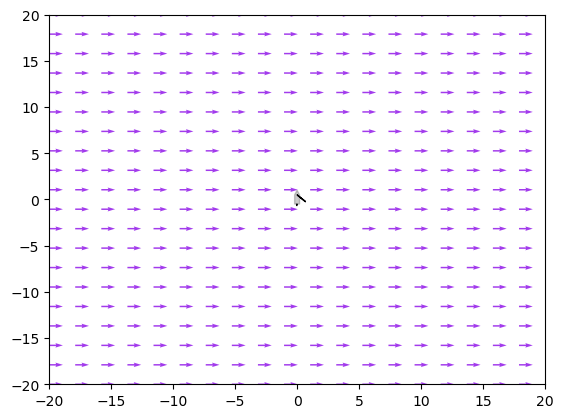

In [14]:
fig, ax = plt.subplots()

def func(k):
    ax.cla()
    plot_wind(ax)
    plot_boat(ax, X[k], U[k], p)
    ax.set_ylim([-20, 20])
    ax.set_xlim([-20, 20])

ani = FuncAnimation(fig, func, frames=range(N-1));
ani.save('test.mp4', writer='ffmpeg', fps=10)

# Free-time Dircol

In [ ]:
p = jnp.array([0.03, 40, 6000, 200, 1500, 0.5, 0.5, 2, 300, 400, 0.2])
x0 = jnp.array([0.0, 0.0, np.pi/2, 0.0, 0.0])
xg = jnp.array([-5.0, 15.0, 0.0, 0.0, 0.0])

N = 60
nx = 5
nu = 2
nz = N*nx + (N-1)*nu + (N-1)
idx_x = [np.array(range(i*(nx+nu+1), i*(nx+nu+1)+nx)) for i in range(N)]
idx_u = [np.array(range(i*(nx+nu+1)+nx, i*(nx+nu+1)+nx+nu)) for i in range(N-1)]
idx_h = [i*(nx+nu+1)+nx+nu for i in range(N-1)]

Q = jnp.diag(jnp.array([1., 1., 0., 0., 0.]))
R = 0.1*jnp.eye(nu)
Qf = 1000*Q

In [ ]:
z0 = np.zeros(nz)
z0[idx_x] = np.linspace(x0, xg, N)
z0[idx_u] = 0.001*np.random.randn(N-1, nu)
z0[idx_h] = 0.1*np.ones(N-1)

# z0 = 0.001*np.random.randn(nz)
# z0[idx_x[0]] = x0
# for i in range(N-1):
#     z0[idx_u[i]] = u
#     z0[idx_h[i]] = 0.1
#     z0[idx_x[i+1]] = rk4(z0[idx_x[i]], z0[idx_u[i]], p, z0[idx_h[i]])

In [ ]:
def cost(z):
    J = 0 
    for i in range(N-1):
        xi = z[idx_x[i]]
        ui = z[idx_u[i]]
        hi = z[idx_h[i]]
        J += hi
        # J += hi * (xi - xg).T @ Q @ (xi - xg)
        # J += ui.T @ R @ ui

    # xf = z[idx_x[N-1]]
    # J += (xf - xg).T @ Qf @ (xf - xg)
    
    return J

In [ ]:
def dyncon(z):
    c = []
    for i in range(N-1):
        xi = z[idx_x[i]]
        xip1 = z[idx_x[i+1]]
        ui = z[idx_u[i]]
        hi = z[idx_h[i]]
        c.extend(hermite_simpson(xi, xip1, ui, p, hi))
    return jnp.array(c)

dynamics_constraint = {
    'type': 'eq',
    'fun': dyncon,
    'jac': jacfwd(dyncon)
}

#* primal bounds
z_bounds = np.array([(None, None) for i in range(nz)])

# initial condition
z_bounds[idx_x[0]] = [(x0[i], x0[i]) for i in range(nx)]

# # final condition
tol = 1.0
z_bounds[idx_x[-1][0]] = (xg[0]-tol, xg[0]+tol)
z_bounds[idx_x[-1][1]] = (xg[1]-tol, xg[1]+tol)

# control + time delta bounds
for k in range(N-1):
    z_bounds[idx_u[k]] = [(-np.pi/3, np.pi/3), (-np.pi/3, np.pi/3)]
    z_bounds[idx_h[k]] = (0.01, 0.5)

In [ ]:
def callback(z):
    print(f'cost: {cost(z)}')
    print(f'dynamics constraint: {np.sum(np.abs(dyncon(z)))}')

callback(z0)
res = minimize(cost, z0, method='SLSQP', jac=jacfwd(cost), bounds=z_bounds, constraints=[dynamics_constraint], callback=callback, options={'maxiter': 20})
print(res)

z = res.x
X = z[idx_x].reshape(N, nx)
U = z[idx_u].reshape(N-1, nu)

In [ ]:
fig, ax = plt.subplots()

def func(k):
    ax.cla()
    plot_wind(ax)
    plot_boat(ax, X[k], U[k], p)
    ax.set_ylim([-20, 20])
    ax.set_xlim([-20, 20])

ani = FuncAnimation(fig, func, frames=range(N-1));
ani.save('test_timeopt.mp4', writer='ffmpeg', fps=10)

## MPC

In [ ]:
import cvxpy as cp
def mpc(A, B, X_ref_window, U_ref_window, xic, xg, u_min, u_max, N_mpc):
    nx,nu = B.shape
    
    Q = 0.01 * np.diag(np.ones(nx))
    R = 0.01 * np.diag(np.ones(nu))

    X = cp.Variable((nx, N_mpc))
    U = cp.Variable((nu, N_mpc-1))

    cost = 0.0
    for k in range(N_mpc-1):
        x = X[:, k]
        u = U[:, k]
        state_cost = cp.quad_form((x - X_ref_window[:, k]), Q)
        
        if U_ref_window is not None:
            input_cost = cp.quad_form(u - U_ref_window[:, k], R)
        else:
            input_cost = cp.quad_form(u, R)

        cost += 0.5 * state_cost + 0.5 * input_cost
    
    cost += 0.5 * cp.quad_form((X[:, N_mpc-1] - X_ref_window[:, N_mpc-1]), Q)

    constraints = [X[:, 0] == xic]

    for k in range(N_mpc-1):
        constraints.append(X[:, k+1] == A @ X[:, k] + B @ U[:, k])
        constraints.append(u_min <= U[:, k])
        constraints.append(U[:, k] <= u_max)
    
    prob = cp.Problem(cp.Minimize(cost), constraints)
    prob.solve(solver=cp.ECOS, verbose=False, abstol=1e-8, reltol=1e-8, feastol=1e-7)
    
    return U[:, 0].value

In [ ]:
p = jnp.array([0.03, 40, 6000, 200, 1500, 0.5, 0.5, 2, 300, 400, 0.2])
x0 = jnp.array([0.0, 0.0, np.pi/2, 0.0, 0.0])
xg = jnp.array([-5.0, 15.0, 0.0, 0.0, 0.0])
u = jnp.array([0, jnp.pi/16])
dt = 0.1
tf = 25

N = int(tf/dt)
nx = 5
nu = 2
nz = (N-1) * nu + N * nx
idx_x = [jnp.array(range(i*(nx+nu), i*(nx+nu)+nx)) for i in range(N)]
idx_u = [jnp.array(range(i*(nx+nu)+nx, i*(nx+nu)+nx+nu)) for i in range(N-1)]

X_ref = z[idx_x].T
U_ref = z[idx_u].T

N_mpc = 10

X_ref = np.pad(X_ref, ((0, 0), (0, N_mpc)), mode='edge')
U_ref = np.pad(U_ref, ((0, 0), (0, N_mpc-1)), mode='edge')

X_mpc = np.zeros((5, N))
X_mpc[:, 0] = x0

U_mpc = np.zeros((2, N-1))

u_min = np.array([-np.pi/3, -np.pi/3])
u_max = np.array([np.pi/3, np.pi/3])

for k in range(N-1):
    A = jacfwd(dynamics, 0)(X_ref[:,k], U_ref[:,k], p)
    B = jacfwd(dynamics, 1)(X_ref[:,k], U_ref[:,k], p)
    
    X_ref_tilde = X_ref[:, k:k+N_mpc]
    U_ref_tilde = U_ref[:, k:k+N_mpc-1]

    x0 = X_ref_tilde[:, 0]
    xg = X_ref_tilde[:, -1]

    U_mpc[:, k] = mpc(A, B, X_ref_tilde, U_ref_tilde, x0, xg, u_min, u_max, 10)
    X_mpc[:, k+1] = rk4(X_mpc[:, k], U_mpc[:, k], p, dt)

In [ ]:
def func(k):
    ax.cla()
    plot_wind(ax)
    plot_boat(ax, X_mpc[:, k], U_mpc[:, k], p)
    ax.set_ylim([-20, 20])
    ax.set_xlim([-20, 20])

ani = FuncAnimation(fig, func, frames=range(N-1))
ani.save('test_mpc.mp4', writer='ffmpeg', fps=10)

In [ ]:
plt.figure()
plt.plot(U_mpc[0, :])
plt.plot(U_ref[0, :])
plt.legend(['u1', 'u2', 'u1_ref', 'u2_ref'])


plt.figure()
plt.plot(X_mpc[0, :])
plt.plot(X_ref[0, :])
plt.legend(['lon', 'lon_ref'])